TREE     CV acc: 0.838±0.008 | VAL acc: 0.830
BAGGING  CV acc: 0.893±0.007 | VAL acc: 0.884
RF       CV acc: 0.892±0.008 | VAL acc: 0.886
GBM      CV acc: 0.846±0.009 | VAL acc: 0.833

=== Summary of Results ===
| Model   | CV Accuracy (mean)   |   Validation Accuracy |
|:--------|:---------------------|----------------------:|
| tree    | 0.838 ± 0.008        |                 0.83  |
| bagging | 0.893 ± 0.007        |                 0.884 |
| rf      | 0.892 ± 0.008        |                 0.886 |
| gbm     | 0.846 ± 0.009        |                 0.833 |


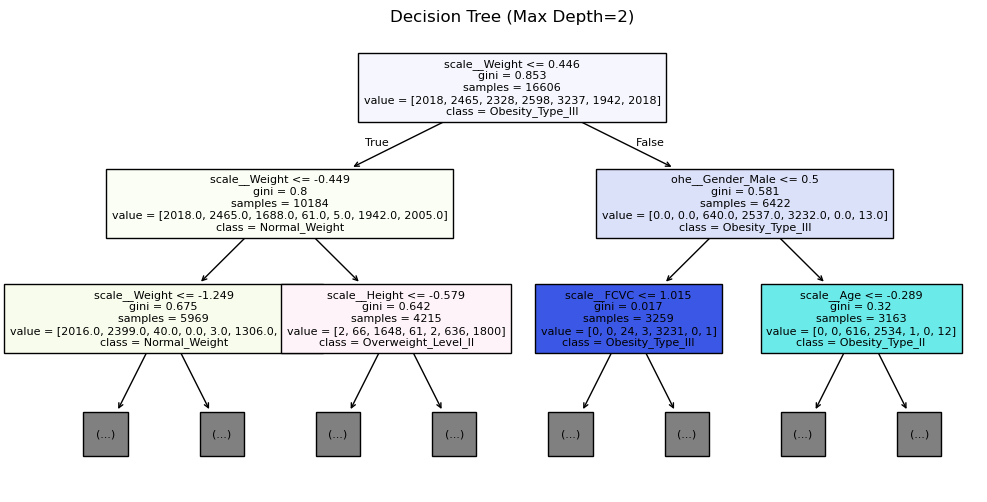


=== TREE ===
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.91      0.90       505
      Normal_Weight       0.83      0.64      0.72       617
     Obesity_Type_I       0.84      0.79      0.81       582
    Obesity_Type_II       0.95      0.94      0.94       650
   Obesity_Type_III       1.00      0.99      1.00       809
 Overweight_Level_I       0.55      0.79      0.65       485
Overweight_Level_II       0.73      0.67      0.70       504

           accuracy                           0.83      4152
          macro avg       0.83      0.82      0.82      4152
       weighted avg       0.84      0.83      0.83      4152



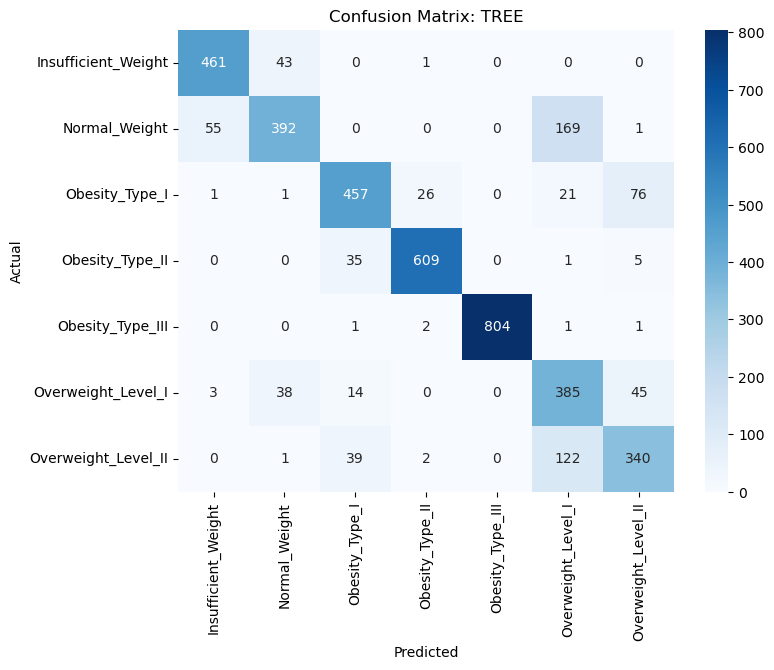


=== BAGGING ===
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.93      0.92       505
      Normal_Weight       0.84      0.85      0.85       617
     Obesity_Type_I       0.86      0.86      0.86       582
    Obesity_Type_II       0.95      0.97      0.96       650
   Obesity_Type_III       1.00      0.99      1.00       809
 Overweight_Level_I       0.77      0.71      0.74       485
Overweight_Level_II       0.77      0.78      0.78       504

           accuracy                           0.88      4152
          macro avg       0.87      0.87      0.87      4152
       weighted avg       0.88      0.88      0.88      4152



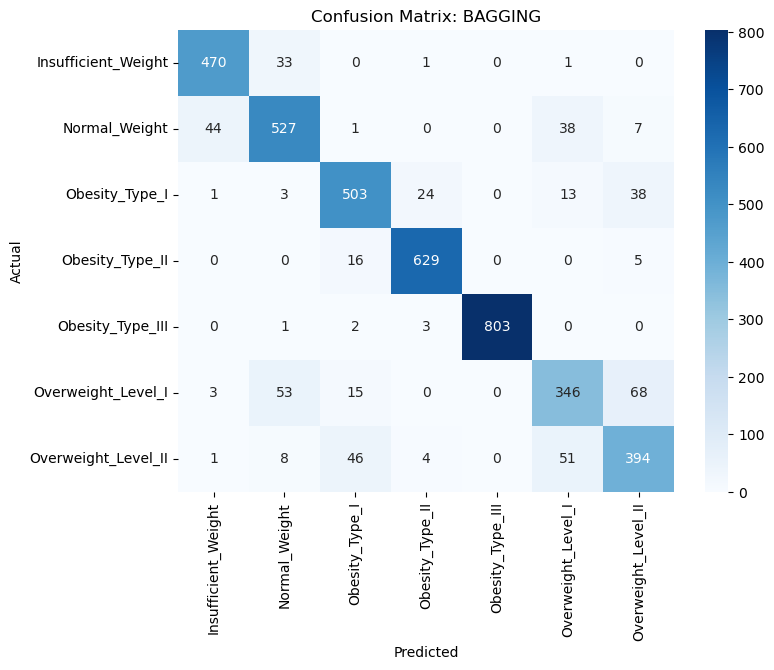


=== RF ===
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.91      0.92       505
      Normal_Weight       0.82      0.88      0.85       617
     Obesity_Type_I       0.88      0.86      0.87       582
    Obesity_Type_II       0.96      0.97      0.96       650
   Obesity_Type_III       1.00      0.99      1.00       809
 Overweight_Level_I       0.77      0.69      0.73       485
Overweight_Level_II       0.76      0.80      0.78       504

           accuracy                           0.89      4152
          macro avg       0.87      0.87      0.87      4152
       weighted avg       0.89      0.89      0.88      4152



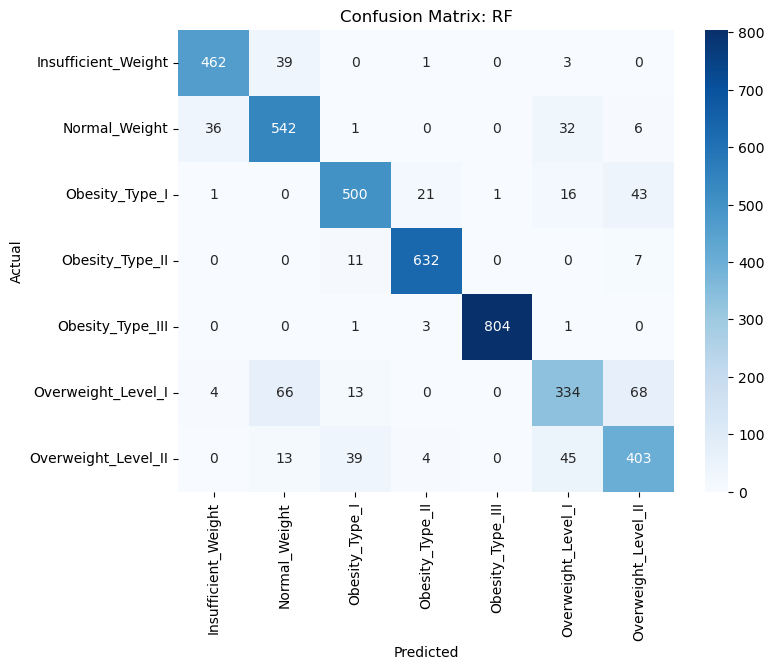


=== GBM ===
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.93      0.89       505
      Normal_Weight       0.74      0.76      0.75       617
     Obesity_Type_I       0.77      0.83      0.80       582
    Obesity_Type_II       0.93      0.95      0.94       650
   Obesity_Type_III       1.00      0.99      0.99       809
 Overweight_Level_I       0.73      0.55      0.63       485
Overweight_Level_II       0.69      0.69      0.69       504

           accuracy                           0.83      4152
          macro avg       0.82      0.81      0.81      4152
       weighted avg       0.83      0.83      0.83      4152



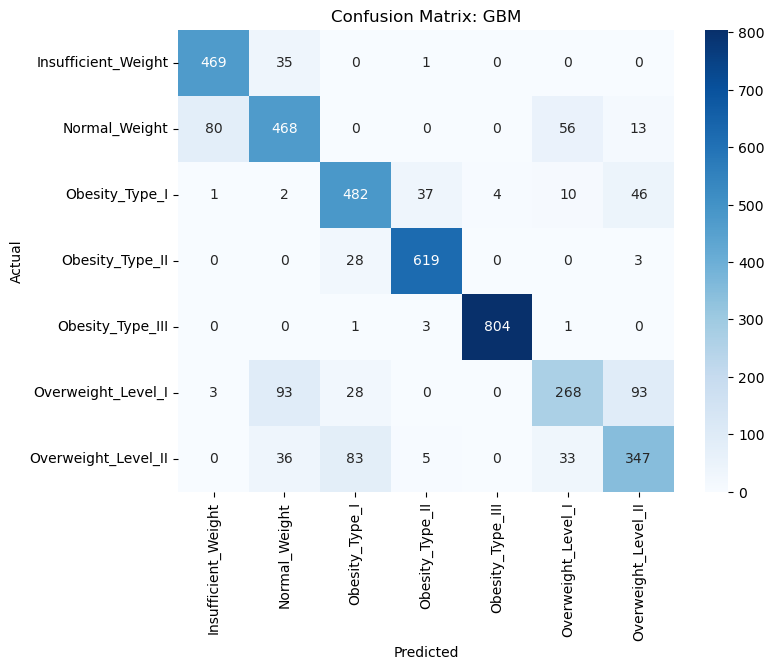

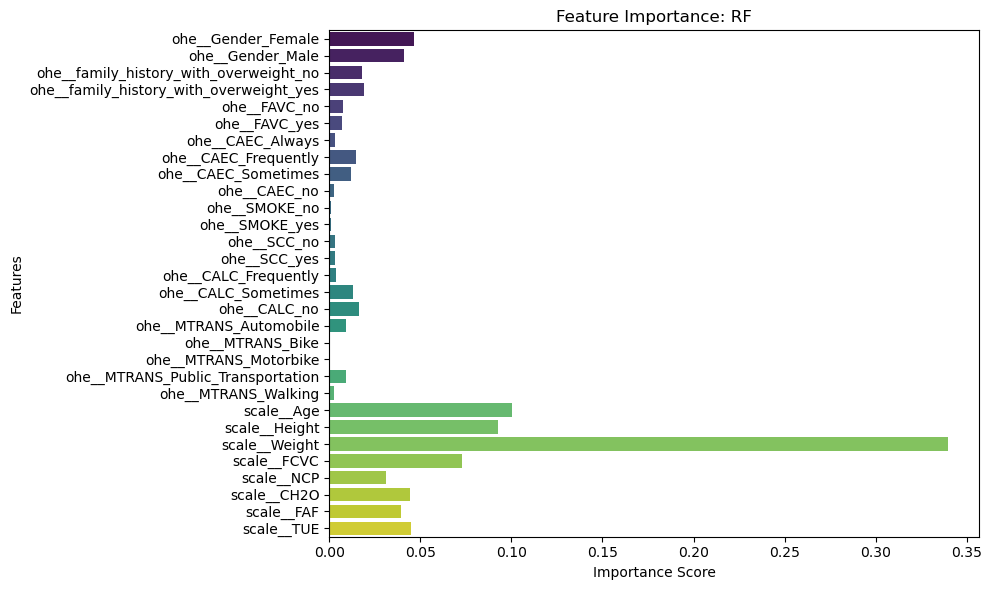

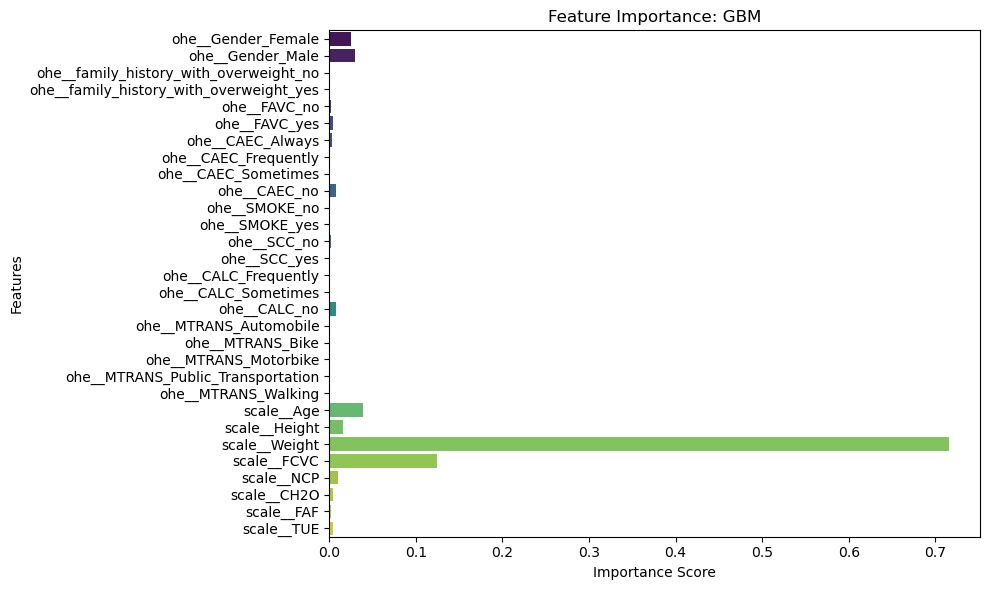

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  

# 1. Settings
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)

# 2. Load
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 3. Split
X = train.drop(['id', 'NObeyesdad'], axis=1)
y = train['NObeyesdad']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# 4. Preprocessor
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC',
            'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
num_cols = [c for c in X.columns if c not in cat_cols]
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

# 5. Models
models = {
    'tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_SEED),
    'bagging': BaggingClassifier(n_estimators=30, random_state=RANDOM_SEED),
    'rf': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'gbm': GradientBoostingClassifier(n_estimators=100, max_depth=1, learning_rate=0.1, random_state=RANDOM_SEED)  #learning_rate
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)

# 6. Train/Evaluate + Store Results (NEW)
results = []  # Store results for tabular output
for name, model in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])
    # Cross-validation
    scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # Validation
    pipe.fit(X_train, y_train)
    val_score = pipe.score(X_val, y_val)
    # NEW: Store results
    results.append({
        'Model': name,
        'CV Accuracy (mean)': f"{scores.mean():.3f} ± {scores.std():.3f}",
        'Validation Accuracy': f"{val_score:.3f}"
    })
    print(f"{name.upper():8} CV acc: {scores.mean():.3f}±{scores.std():.3f} | VAL acc: {val_score:.3f}")

# Print results as a table
print("\n=== Summary of Results ===")
print(pd.DataFrame(results).to_markdown(index=False))

# 7. Detailed for tree
dt_pipe = Pipeline([('prep', preprocessor), ('dt', models['tree'])])
dt_pipe.fit(X_train, y_train)
plt.figure(figsize=(12, 6))
plot_tree(models['tree'], max_depth=2,
          feature_names=preprocessor.get_feature_names_out(),
          class_names=models['tree'].classes_,
          filled=True, fontsize=8)
plt.title("Decision Tree (Max Depth=2)")  #Added title
plt.show()

# 8. Classification reports & confusion matrices
for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    print(f"\n=== {name.upper()} ===")
    print(classification_report(y_val, y_pred))
    # Visualize confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix: {name.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Feature Importance for Random Forest and GBM
for name in ['rf', 'gbm']:
    pipe = Pipeline([('prep', preprocessor), ('model', models[name])])
    pipe.fit(X_train, y_train)
    importances = pipe.named_steps['model'].feature_importances_
    features = pipe.named_steps['prep'].get_feature_names_out()
    # Plot 
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features, hue=features, palette='viridis', legend=False) 
    plt.title(f'Feature Importance: {name.upper()}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

# 9. Create submissions 
for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    pipe.fit(X, y)
    preds = pipe.predict(test.drop('id', axis=1))
    pd.DataFrame({'id': test['id'], 'NObeyesdad': preds}) \
        .to_csv(f'submission_{name}.csv', index=False)